In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
import gc; gc.enable()


%matplotlib inline

In [3]:
df = pd.read_csv('./data/data.csv')

In [4]:
df=df.rename(columns = {"Unnamed: 0": "Date"})

In [5]:
df.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
146659,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
146660,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
146661,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
146662,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
146663,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [6]:
df.Date = pd.to_datetime(df.Date)

In [7]:
df.set_index('Date', inplace = True)

In [8]:
df.sort_index(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


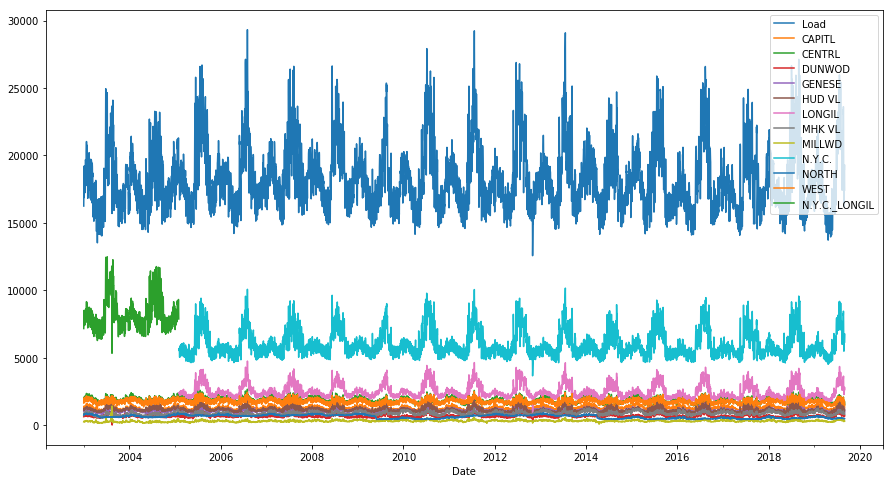

In [10]:
days = df.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

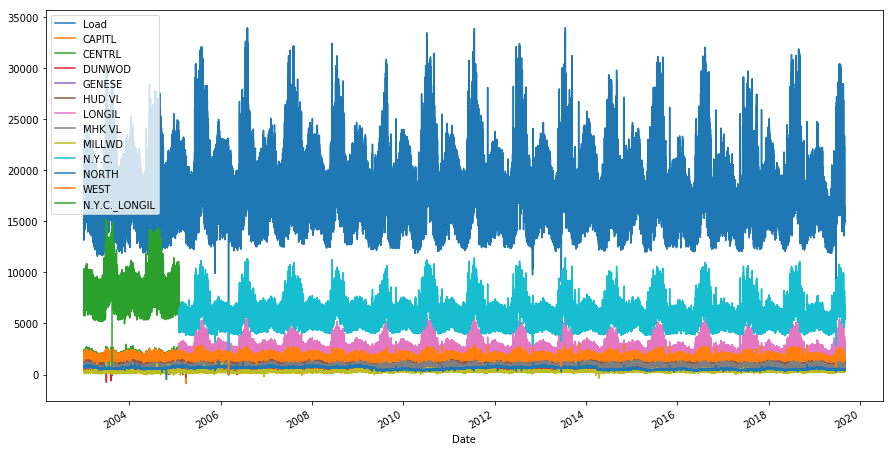

In [11]:
df.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [12]:
df.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-08-31 19:00:00,18978.866667,1432.041667,1704.391667,755.041667,1045.016667,1219.691667,3035.408333,890.116667,343.716667,6431.391667,518.683333,1603.366667,NaN
2019-08-31 20:00:00,18835.633333,1444.800000,1701.433333,747.925000,1050.491667,1205.100000,2950.483333,894.091667,339.916667,6391.741667,491.141667,1618.508333,NaN
2019-08-31 21:00:00,18256.466667,1398.208333,1639.766667,728.100000,1008.441667,1142.266667,2787.541667,868.941667,330.808333,6281.708333,492.925000,1577.758333,NaN
2019-08-31 22:00:00,17426.316667,1318.433333,1554.750000,694.583333,952.525000,1066.483333,2598.775000,815.766667,311.116667,6107.491667,485.675000,1520.716667,NaN
2019-08-31 23:00:00,16364.112500,1225.181250,1441.912500,651.893750,888.337500,980.656250,2389.050000,746.581250,277.956250,5860.143750,488.106250,1414.293750,NaN


In [13]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [14]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [15]:
def cyc_feats(df, feat):
    start = df.index[0].date().year-1
    df['cyc_{0}_x'.format(str(feat))] = np.cos(((2*np.pi)/df[feat])*(df['year']-(start))) #x-coord
    df['cyc_{0}_y'.format(str(feat))] = np.sin(((2*np.pi)/df[feat])*(df['year']-(start))) #y-coord
    return df

In [207]:
def create_features(df, tar):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in [14, 28, 60, 90]:
        df['MA_{0}'.format(str(i))] = df[tar].rolling(24*i).mean() # rolling average
        df['MMAX_{0}'.format(str(i))] = df[tar].rolling(24*i).max() # rolling maximum
        df['MMIN_{0}'.format(str(i))] = df[tar].rolling(24*i).min() # rolling minimum
        df['MSTD_{0}'.format(str(i))] = df[tar].rolling(24*i).std() # rolling standard deviation
        df['MSLOPE_{0}'.format(str(i))] = df[tar].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        df['MACC_{0}'.format(str(i))] = df[tar].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180, 365]:
        # add the lagged Load as a feature
        df['lag_{0}'.format(str(i))] = df[tar].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df[tar]
   
    #create cyclical features
    feats = ['month', 'dayofmonth', 'dayofyear', 'weekofyear']
    for feat in feats:
        df = cyc_feats(df, feat)
    return df

In [17]:
def split_data(data, split_date):
    return data[data.index < split_date].copy(), \
               data[data.index >=  split_date].copy()

In [21]:
def data_prep(data, isTest=0):
    used_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
    keep_cols = used_cols
    if isTest:
        pass
    else:
        keep_cols += [target]
    used_cols = [col for col in keep_cols if col not in [target, _id]]
    return data[keep_cols].copy(), keep_cols, used_cols

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 20.7 MB


In [23]:
df.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    128439
dtype: int64

In [24]:
#drop NaNs
target = 'Load'
df.dropna(subset = [target], inplace=True)
df.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [25]:
df.shape

(146034, 13)

In [26]:
drop_cols = [col for col in df.columns.tolist() if col not in [target]]

In [27]:
df.drop(drop_cols, axis=1, inplace=True)

In [28]:
df.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [208]:
df_ = df['01-01-2017':'07-31-2019'].copy()

In [209]:
df_ = create_features(df_, target)

In [210]:
df_.dropna(inplace=True)

In [211]:
df_.head()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,18942.233333,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,...,15763.208333,0.832173,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 02:00:00,18469.283333,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,...,15071.408333,0.816026,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 03:00:00,18163.875000,2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,...,14485.033333,0.797464,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 04:00:00,18009.541667,2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,...,14097.658333,0.782788,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 05:00:00,18158.241667,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,...,13937.300000,0.767547,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16


In [212]:
df_.tail()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,2019-07-31 19:00:00,19,2,3,7,2019,212,31,31,...,24804.641667,0.998778,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 20:00:00,24219.675000,2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,...,24019.750000,0.991745,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 21:00:00,23578.041667,2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,...,23664.100000,1.003650,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 22:00:00,22177.316667,2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,...,23159.708333,1.044297,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 23:00:00,20562.291667,2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,...,21818.275000,1.061082,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268


In [213]:
train, test = split_data(df_, '07-01-2019')

In [214]:
y = train[target].shift(-24).dropna()

In [215]:
_id = 'date'
train, keep_cols, used_cols = data_prep(train)

In [216]:
X = train[used_cols].iloc[:-24,:]

In [217]:
X.shape

(13077, 54)

In [218]:
y.shape

(13077,)

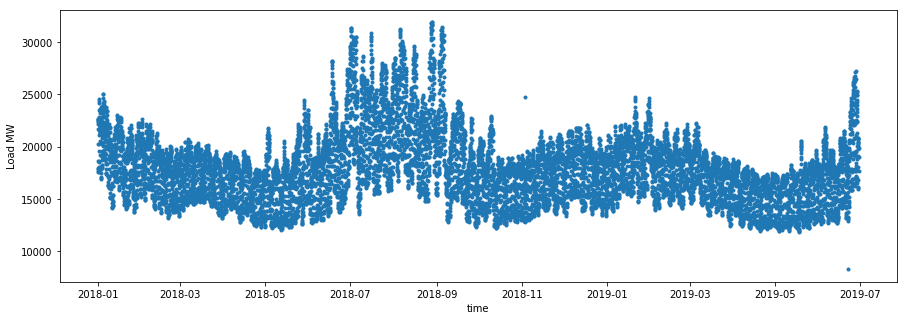

In [219]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load MW')
plt.plot(X.index,y, '.')
# plt.plot(X_test.index,y_test, '.')
plt.show()

In [220]:
reg = xgb.XGBRegressor()

In [221]:
reg.fit(X, y, 
        eval_set=[(X, y)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [222]:
evals_result = reg.evals_result()

In [166]:
# evals_result

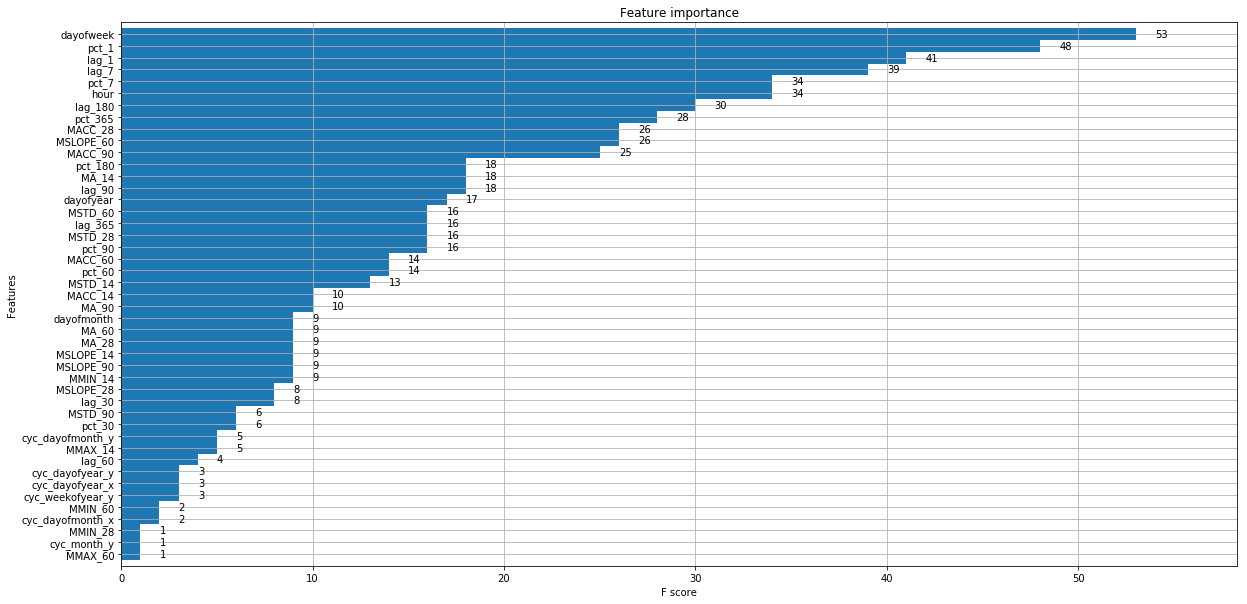

In [223]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height = 1)

In [224]:
# feats = reg.get_booster().get_score(importance_type="weight")
# feats

In [225]:
test, keep_cols, used_cols = data_prep(test)

In [226]:
y_pred = reg.predict(test[used_cols])


In [227]:
y_test = df['07-02-2019':'08-01-2019'][target].copy()

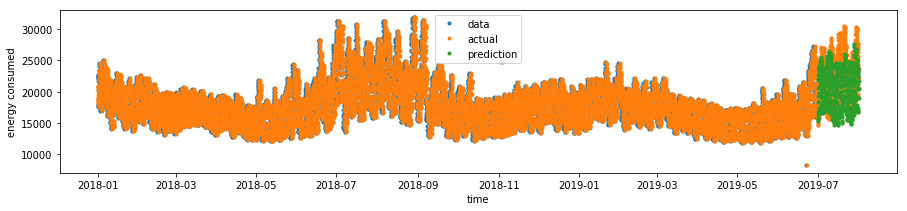

In [228]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X.index, y, '.', label='data')
plt.plot(df_.index, df_[target], '.', label='actual')
plt.plot(test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [229]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, '-', label='actual')
    plt.plot(test.index, y_pred, '-', label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

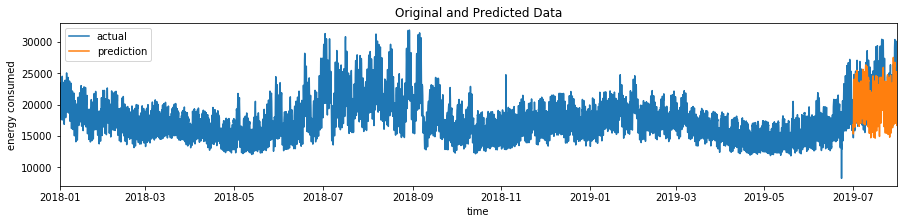

In [230]:
plot_(df_, df_[target], df_.index[0].date(), df_.index[-1].date(), 'Original and Predicted Data')

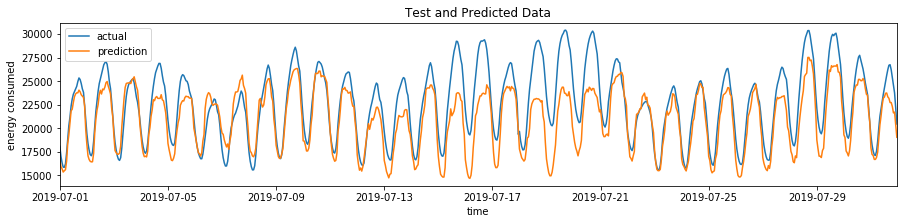

In [231]:
plot_(test, y_test, test[target].index[0], test[target].index[-1], 'Test and Predicted Data')

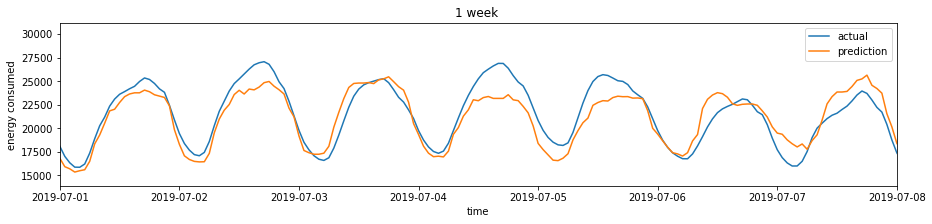

In [232]:
plot_(test, y_test, '07-01-2019', '07-08-2019', "1 week ")

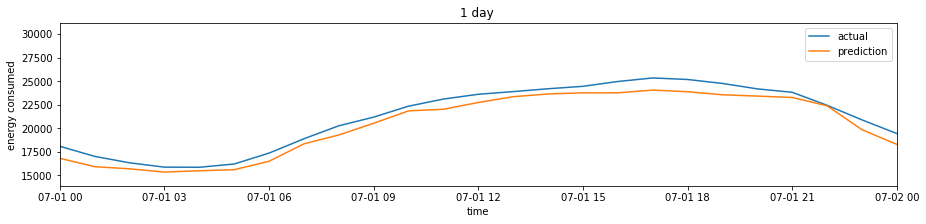

In [234]:
plot_(test, y_test, '07-01-2019', y_test.index[0], "1 day ")

In [235]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from numba import jit
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [236]:
def forecast_error(y_true, y_pred):
    return y_true - y_pred

In [237]:
def mean_forecast_error(forecast_error):
    return forecast_error.mean()

In [238]:
def smape(A, F):
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [239]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

5875677.637650339


In [240]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

1892.056237572443


In [241]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

8.093440531154869


In [242]:
sMAPE = smape(y_test, y_pred)
print(sMAPE)

8.570857126235575


In [243]:
sMAPE = smape(y_test[:24], y_pred[:24])
print(sMAPE)

3.885882448704421


In [244]:
RMSE = np.sqrt(MSE)
print(RMSE)

2423.979710651543


In [142]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

1571.4085018613168


In [143]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.5744420249507424


In [ ]:
samp_ = df['01-01-201':'07-31-2019'].copy()

In [193]:
k = 3
idx = df_.index[0]
for i in range(0,k):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-193-41c1bb377676>, line 4)

In [192]:
df_.shape

(18285, 54)

In [202]:
idx = df_.index[0]

KeyError: datetime.date(2017, 6, 30)

In [197]:
idx+(24*365)

ValueError: Cannot add integral value to Timestamp without freq.